# Simulating Non-Line-of-Sight captures with mitransient

## Overview
<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>
  
  Import `mitransient` and configure it for Non-Line-of-Sight (NLOS) scenes</li>
  <li>
  
  Setup an NLOS scene, including the relay wall, laser, camera and hidden geometry</li>
  <li>
  
  Visualize the output capture</li>
</ul>

</div>

In this tutorial, you will use mitransient to simulate a non-line-of-sight (NLOS) scene with mitransient. If you are not familiar, NLOS imaging algorithms use indirect light scattered in the scene to reconstruct hidden objects, for example around a corner. For this example, we will target a Z-shaped geometry defined in `Z.obj`. The scene's camera will not directly capture light from the Z object, but instead capture indirect light that has bounced on a rectangular *relay wall*. The key elements in the scene will be:
1. The **hidden Z-shaped object**
2. The **relay wall**, defined with the `rectangle` plugin, which contains a `nlos_capture_meter` (a **sensor** to measure indirect light)
3. A **laser source** that illuminates the relay wall. We will show how to position and orient this source so that it illuinates points on the relay wall

### Importing `mitransient`
Before importing `mitransient`, you need to import Mitsuba 3 and set a variant (here we use `llvm_ad_rgb`). Only if you want to use more variants, you will need to compile Mitsuba 3 (not `mitransient`) yourself. And you will need to add the compilation folder to the `PYTHONPATH` (see the commented code for how to do that).

<div class="admonition important alert alert-block alert-warning">

For many cases, `mitransient` requires the use of a `llvm_*` or `cuda_*` variant, so we don't recommend using `scalar_rgb`. It will work with any `llvm_*` or `cuda_*` variant, and for most use cases `llvm_ad_rgb` or `cuda_ad_rgb` is enough. [You can see a full explanation of mitsuba's variants here.](https://mitsuba.readthedocs.io/en/stable/src/key_topics/variants.html)

**If you have a GPU we really recommend using `cuda_*` variants as they'll make the process much faster.**

</div>

<div class="admonition important alert alert-block alert-warning">

**Maybe if you plan to do NLOS simulations it can be worth to do `llvm_mono` or `cuda_mono`, which only uses one wavelength instead of three RGB channels, and thus is faster.**

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_mono')

import mitransient as mitr

print('Using mitsuba version:', mi.__version__)
print('Using mitransient version:', mitr.__version__)

Using mitsuba version: 3.7.0
Using mitransient version: 1.2.0


### Setup the NLOS scene

In this tutorial you will learn how to prepare a NLOS scene using our library. We will do it following a programmatical way defining each component independently. Here we do it with `mi.load_dict`, but we also provide a `nlos_Z.xml` file which can be loaded with `mi.load_file` and gives the same results. Note that the conversion from XML and dictionaries is fairly straightforward.

<div class="admonition important alert alert-block alert-success">

If you want to learn more about the parameters of each plugin (geometry, emitter, transient_film, etc.), you can check [Mitsuba 3's documentation](https://mitsuba.readthedocs.io/en/stable/src/plugin_reference.html), and our documentation ([integrators](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_integrators.html), [films](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_films.html), [sensors](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_sensors.html), [other functions](https://mitransient.readthedocs.io/en/latest/src/other.html))

</div>

In [2]:
# Load the geometry of the hidden scene
geometry = mi.load_dict(
    {
        "type": "obj",
        "filename": "./Z.obj",
        "to_world": mi.ScalarTransform4f().translate([0.0, 0.0, 1.0]),
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
    }
)

# Load the emitter (laser) of the scene
emitter = mi.load_dict(
    {
        "type": "projector",
        "irradiance": 100.0,
        "fov": 0.2,
        "to_world": mi.ScalarTransform4f().translate([-0.5, 0.0, 0.25]),
    }
)

# Define the transient film which store all the data
transient_film = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 25_000},
        "sensor_origin": mi.ScalarPoint3f(-0.5, 0.0, 0.25),
        "transient_film": transient_film,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
        "nlos_sensor": nlos_sensor,
    }
)

# Finally load the integrator
from mitransient.integrators.transientnlospath import CaptureType
integrator = mi.load_dict(
    {
        "type": "transient_nlos_path",
        "nlos_laser_sampling": True,
        "nlos_hidden_geometry_sampling": True,
        "nlos_hidden_geometry_sampling_do_rroulette": False,
        "account_first_and_last_bounces": False,
        "capture_type": int(CaptureType.Single),
        "temporal_filter": "box",
    }
)

In [3]:
# Assemble the final scene
scene = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall,
    'integrator' : integrator
})

In [4]:
# Now we focus the emitter to irradiate one specific pixel of the "relay wall"
pixel = mi.Point2f(32, 32)
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall, emitter)

### Render the scene in steady and transient domain

In [5]:
data_steady, data_transient = mi.render(scene)

The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) A transient image `data_transient` with dimensions (width, height, time, channels)

`data_steady` would be the result of a conventional (non-transient) render i.e. `data_steady = data_transient.sum(axis=2)`

## Visualize the steady and transient image
We provide different functions so you can visualize your data in a Jupyter notebook

### Visualize the transient image

The important part for NLOS imaging is `data_transient`, which contains the time-resolved indirect illumination. Here we show how to visualize it.

In [6]:
'''
data_transient is a 4D array represented as a Dr.JIT's TensorXf class.
It is very similar to a numpy array (in fact, you can convert between
the two by using np.array(data_transient))
'''
print(data_transient.__class__.__name__)
# The channels represent (x, y, time, rgb)
print(data_transient.shape)

TensorXf
(64, 64, 300, 1)


#### Plot radiance at one pixel over time

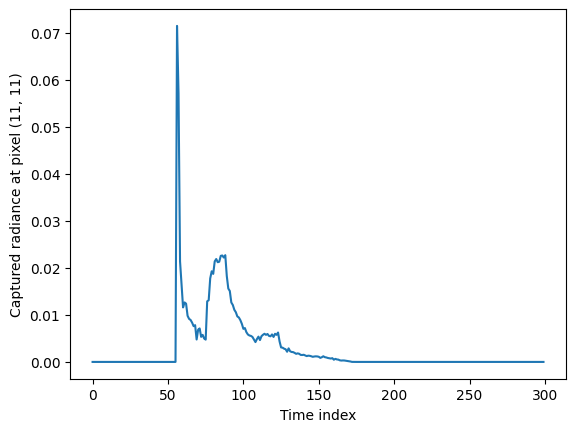

In [7]:
import numpy as np
import matplotlib.pyplot as plt

i, j = 11, 11

# There are two main ways of plotting data_transient
# The first one is to plot a single pixel's time-resolved response
plt.plot(np.array(data_transient)[i, j, :, 0])
plt.xlabel('Time index')
plt.ylabel(f'Captured radiance at pixel ({i}, {j})')
plt.show()

#### Plot radiance at all pixels in the relay wall at one time instant

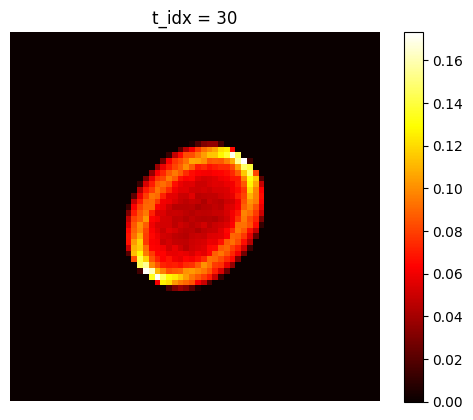

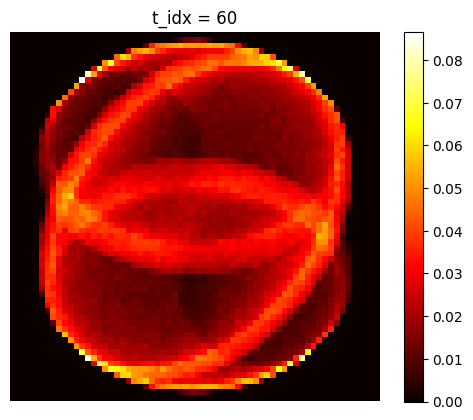

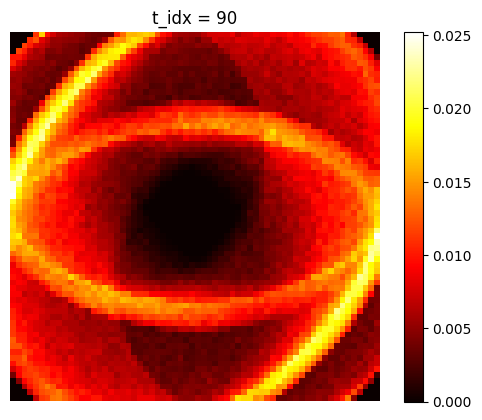

In [8]:
# The second one is to plot a frame of the transient video
# To understand this image, you can look at the paper:
# Non-Line-of-Sight Transient Rendering, Figure 4

def plot_time_instant(t):
    plt.imshow(np.array(data_transient)[:, :, t, 0], cmap='hot')
    plt.colorbar()
    plt.axis('off')
    plt.xlabel('Relay wall X')
    plt.ylabel('Relay wall Y')
    plt.title(f't_idx = {t}')
    plt.show()

plot_time_instant(30)
plot_time_instant(60)
plot_time_instant(90)

In [9]:
# mitransient offers a utility function to show videos

mitr.vis.show_video(data_transient, 2)

# Confocal captures
Regular NLOS captures will scan the relay wall while only illuminating a single point (also known as 'Single' captures).
However, the information that can be recovered with these captures is limited.

*Confocal* captures try to circumvent this limitation by aiming the light source at different points of the relay wall.
Each time a point of the *relay wall* is scanned by the sensor, the emitter will be aimed to illuminate that same point.
Therefore, by illuminating the hidden scene from different points of view, confocal caputres obtain more information of the hidden scene.

To use confocal captures, simply change the capture type of the integrator from ```CaptureType.Single``` to ```CaptureType.Confocal```.


In [10]:
# Create a new confocal integrator, and update the mitsuba scene
confocal_integrator = mi.load_dict(
    {
        "type": "transient_nlos_path",
        "nlos_laser_sampling": True,
        "nlos_hidden_geometry_sampling": True,
        "nlos_hidden_geometry_sampling_do_rroulette": False,
        "account_first_and_last_bounces": False,
        "capture_type": int(CaptureType.Confocal),
        "temporal_filter": "box",
    }
)

scene = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall,
    'integrator' : confocal_integrator
})

# NOTE: no need to focus the emitter! The integrator takes care of focusing towards each of the scanned points

In [11]:
# Render the scene
data_steady, data_transient = mi.render(scene)

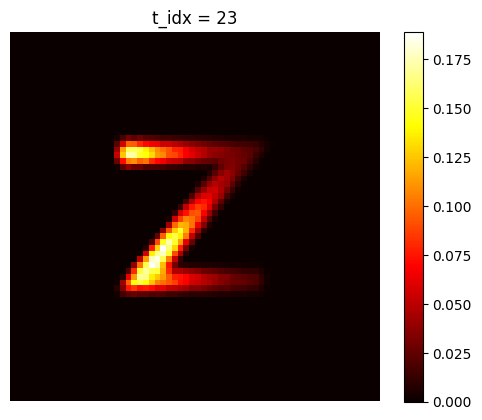

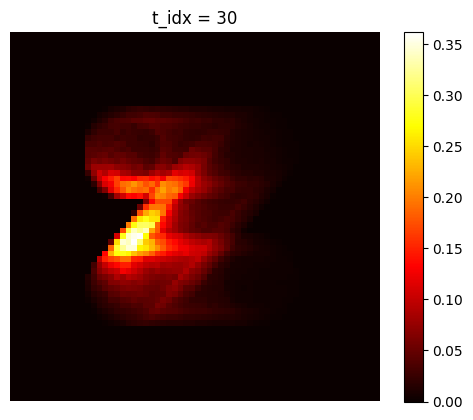

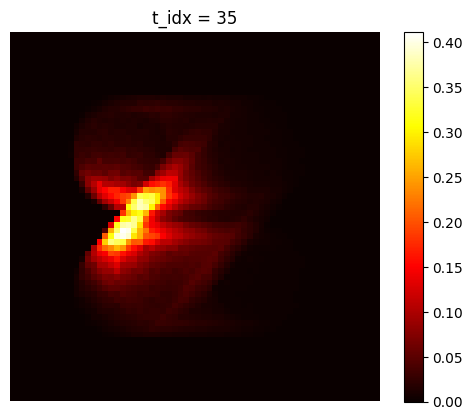

In [12]:
# Plot the simulated signal
def plot_time_instant(t):
    plt.imshow(np.array(data_transient)[:, :, t, 0], cmap='hot')
    plt.colorbar()
    plt.axis('off')
    plt.xlabel('Relay wall X')
    plt.ylabel('Relay wall Y')
    plt.title(f't_idx = {t}')
    plt.show()

plot_time_instant(23)
plot_time_instant(30)
plot_time_instant(35)

In [13]:
mitr.vis.show_video(data_transient, 2)

<div class="admonition important alert alert-block alert-success">


💡 For additional tools, check out `y-tal`, which has multiple NLOS reconstruction algorithms already implemented. [Click here to check `y-tal`.](https://github.com/diegoroyo/tal)
</div>